# INDEX
1. `Import`
2. `Function` : 사용할 함수 파트
3. `Data Load` : 데이터를 불러오고, train df 의 경우 StratifiedKFold 학습을 위해 미리 fold feature 생성
4. `Feature engineering`  
    FE 파트. 특정 FE 는 오래걸리므로 pickle dump, load 사용하여 시간 단축.  
    오래걸리는 FE 는 pickle dump 상위에 배치
5. `Feature selection`  
    학습에 이용할 Feature 선택
6. `Modeling and Training with Cross Validation`  
    modeling and training  
    변수 **STRATIFY_TRAINING** : `True` or `False` 에 따라 Stratifying 학습을 할 지, train_valid 학습을 할 지 선택.
7. `Prediction 분석` : 예측한 값을 분석합니다.
8. `TO DO` : 개선파트 기록

# 1. Import

In [350]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
import os
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from warnings import filterwarnings
from time import time
import pickle
from glob import glob

filterwarnings('ignore')

# 2. Function

In [351]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True): 
    '''
    사용자 기준으로 묶어서 분리함.
    
    :param df: dataframe
    :param ratio: 전체 interaction 데이터 대비 비율
    :param split: True 
    
    :return: 
            train : train 데이터
            test : valid 데이터 (마지막 interaction 만 추출)
    '''
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [352]:
# 사용자별로 묶음과 동시에 사용자별 문제풀이 수를 고려하여 Stratify 분리 (Stratifying CV 학습과 동시 고려)
def make_train_valid_skf(train, n_split=5):
    '''
    데이터에서 문제를 많이 풀 수록 정답률이 올라가므로, 푼 문제 수에 대해서도 균등한 분리를 해주어야 정확한 학습.
    shuffle + 문제풀이 수 고려하여 분리.
    
    :param train: 학습을 위한 train 데이터
    :param n_split: Stratify split number
    
    :return: 
            균등하게 fold 가 구성된 train df
    '''
    skf = StratifiedKFold(n_splits = n_split, shuffle=True)
    
    train_stratify = train['userID'].value_counts().to_frame('num')
    train_stratify['group'] = train_stratify['num']//170
    train_stratify['fold'] = 0
    
    for i, (train_index, valid_index) in enumerate(skf.split(train_stratify, train_stratify.group)):
        train_stratify.loc[train_stratify.iloc[valid_index].index, 'fold'] = i

    train_stratify.reset_index(inplace=True)
    train_stratify.rename(columns = {'index':'userID'}, inplace=True)
    train = pd.merge(train, train_stratify[['userID','fold']], how='left', on = 'userID')
    return train

In [353]:
def split_kfold(train, test, fold_num, FEATS=FEATURES):
    '''
    Fold 에 따라 train/valid set 을 나누고 학습과 추론에 필요한 dataframe 을 구축하는 함수
    
    :param train: train df
    :param test: test df
    :param fold_num: train/valid set 을 구분하기 위한 KFold number
    :param FEATS: 학습에 사용할 FEATURES
    
    :return: 
            X_train_df, y_train, X_valid_df, y_valid, test_df
    '''
    
    X_train = train[train['fold'] != fold_num]
    X_valid = train[train['fold'] == fold_num]
    X_valid = X_valid[X_valid['userID'] != X_valid['userID'].shift(-1)]
    test = test[test['userID'] != test['userID'].shift(-1)]
    # 사용할 Feature 설정 (기존 baseline 은 numeric data 만 이용)
    # FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
    #          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']

    FEATS = FEATURES

    y_train = X_train['answerCode']
    X_train = X_train.drop(['answerCode'], axis=1)

    y_valid = X_valid['answerCode']
    X_valid = X_valid.drop(['answerCode'], axis=1)

    test = test.drop(['answerCode'], axis=1)

#     print(f"X_train    : {str(X_train.shape):15s} / y_train : {y_train.shape}")
#     print(f"X_valid    : {str(X_valid.shape):15s} / y_valid : {y_valid.shape}")
#     print(f"test       : {str(test.shape):15s}")

#     lgb_train = lgb.Dataset(X_train[FEATS], y_train)
#     lgb_valid = lgb.Dataset(X_valid[FEATS], y_valid)
    X_train_df = X_train[FEATS]
    X_valid_df = X_valid[FEATS]
    test_df = test[FEATS]

#     print(f"\nUse FEATURES : {FEATS}\n")

#     print(f"X_train_df : {str(X_train_df.shape):15s} / y_train : {y_train.shape}")
#     print(f"X_valid_df : {str(X_valid_df.shape):15s} / y_valid : {y_valid.shape}")
#     print(f"test_df    : {str(test_df.shape):15s}")
    
    return X_train_df, y_train, X_valid_df, y_valid, test_df

In [354]:
def write_pickle(data, file):    
    '''
    pickle 로 덮어쓰기
    
    :param data: dataframe
    :param file: file 이름
    
    :return: 
            None
    '''
    pickle_path = os.path.join(data_dir, f'{file}_data.pickle')
    with open(pickle_path, 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        
def load_pickle(file):
    '''
    pickle 파일 불러오기
    
    :param file: file 이름
    
    :return: 
            file 이름에 해당하는 dataframe 반환
    '''
    
    pickle_path = os.path.join(data_dir, f'{file}_data.pickle')
    if pickle_path in glob(data_dir + '/*'):
        with open(pickle_path, 'rb') as f:
            data = pickle.load(f)
    return data

In [434]:
def distribution_draw(y_valid, valid_result):
    '''
    valid_y_true 값과 valid 예측값을 인수로 받아 분포를 그리는 함수
    
    :param y_valid: y_true 값
    :param valid_result: valid 예측값
    
    :return:
        check_pred: 예측값과 true 값에 해당하는 dataframe 을 반환
        check_zero: check_pred 중 true 값이 0 인 df 를 반환
        check_one: check_pred 중 true 값이 1 인 df 를 반환
    '''
    check_pred = pd.DataFrame(y_valid)
    check_pred.rename(columns = {'answerCode':'answer'}, inplace=True)
    check_pred['pred'] = valid_result
    check_zero = check_pred[check_pred['answer'] == 0].sort_values(by=['pred'], ascending=False)
    check_one = check_pred[check_pred['answer'] == 1].sort_values(by=['pred'])

    plt.figure(figsize=(16,5))
    plt.hist(list(check_zero['pred']), 
             bins=20, 
             rwidth=0.9, 
             label='pred zero', 
             alpha = 0.5);
    plt.hist(list(check_one['pred']), 
             bins=20, 
             rwidth=0.9, 
             label='pred one',
             alpha = 0.5);
    plt.legend(loc='upper left')
    plt.title('Prediction for 0 and 1 - Distribution', 
              fontweight='bold', 
              loc='left', size=20)
    plt.show();
    return check_pred, check_zero, check_one

----
# 3. Data Load

In [355]:
%%time
data_dir = '/opt/ml/input/data/train_dataset'
csv_file_path = os.path.join(data_dir, 'train_data.csv')
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
sub_csv_file_path = os.path.join(data_dir, 'sample_submission.csv')

train = pd.read_csv(csv_file_path) 
test = pd.read_csv(test_csv_file_path)

# Fold group 생성
train = make_train_valid_skf(train, n_split=5)

display(train.head(), train.shape, test.head(), test.shape)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,fold
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,4
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,4
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,4
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4


(2266586, 7)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623


(260114, 6)

CPU times: user 3.26 s, sys: 376 ms, total: 3.64 s
Wall time: 3.64 s


# 4. FEATURE ENGINEERING
1. 숫자 통계량 추가
2. 카테고리 통계량 추가
3. 숫자 + 카테고리 통계량 추가
4. 교호작용
5. Feature engineering (ex-lag feature, time series)

In [356]:
%%time
# 유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
train.sort_values(by=['userID', 'Timestamp'], inplace=True)
test.sort_values(by=['userID', 'Timestamp'], inplace=True)

CPU times: user 7.91 s, sys: 340 ms, total: 8.25 s
Wall time: 8.25 s


In [357]:
write_pickle(train, 'train')
write_pickle(test, 'test')
print(f"train shape : {train.shape}")
print(f"test shape : {test.shape}")

train shape : (2266586, 7)
test shape : (260114, 6)


`시간이 오래걸리는 FE 는 pickle 위에 추가하고 pickle 로 덮어씌우기`

In [361]:
train = load_pickle('train')
test = load_pickle('test')
print(f"train shape : {train.shape}")
print(f"test shape : {test.shape}")

train shape : (2266586, 7)
test shape : (260114, 6)


In [362]:
display(train.head(), train.shape)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,fold
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,4
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,4
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,4
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4


(2266586, 7)

## 4-1. 숫자 관련 통계량

In [363]:
#유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
train['user_correct_answer'] = train.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
train['user_total_answer'] = train.groupby('userID')['answerCode'].cumcount()
train['user_acc'] = train['user_correct_answer']/train['user_total_answer']

# testId와 KnowledgeTag의 전체 정답률은 한번에 계산
# 아래 데이터는 제출용 데이터셋에 대해서도 재사용
correct_t = train.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
correct_t.columns = ["test_mean", 'test_sum']
correct_k = train.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
correct_k.columns = ["tag_mean", 'tag_sum']

train = pd.merge(train, correct_t, on=['testId'], how="left")
train = pd.merge(train, correct_k, on=['KnowledgeTag'], how="left")
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,fold,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,4,NaN,0,NaN,0.947683,1268,0.955022,637
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,4,1.0,1,1.0,0.947683,1268,0.913187,3040
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,4,2.0,2,1.0,0.947683,1268,0.913187,3040
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4,3.0,3,1.0,0.947683,1268,0.913187,3040
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.0,0.947683,1268,0.913187,3040


In [364]:
#유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
test['user_correct_answer'] = test.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
test['user_total_answer'] = test.groupby('userID')['answerCode'].cumcount()
test['user_acc'] = test['user_correct_answer']/test['user_total_answer']

# testId와 KnowledgeTag의 전체 정답률은 한번에 계산
# 아래 데이터는 제출용 데이터셋에 대해서도 재사용
correct_t = test.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
correct_t.columns = ["test_mean", 'test_sum']
correct_k = test.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
correct_k.columns = ["tag_mean", 'tag_sum']

test = pd.merge(test, correct_t, on=['testId'], how="left")
test = pd.merge(test, correct_k, on=['KnowledgeTag'], how="left")
test.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,NaN,0,NaN,0.473214,106,0.587097,91
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1.0,1,1.000000,0.473214,106,0.587097,91
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,2.0,2,1.000000,0.473214,106,0.588517,123
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,2.0,3,0.666667,0.473214,106,0.588517,123
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,2.0,4,0.500000,0.473214,106,0.581986,252


----
# 5. FEATURE SELECTION

In [365]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,fold,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,4,NaN,0,NaN,0.947683,1268,0.955022,637
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,4,1.0,1,1.0,0.947683,1268,0.913187,3040
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,4,2.0,2,1.0,0.947683,1268,0.913187,3040
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4,3.0,3,1.0,0.947683,1268,0.913187,3040
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,4,1.0,0.947683,1268,0.913187,3040


In [366]:
# 학습에 사용할 FEATURES
#FEATURES = ['KnowledgeTag']
FEATURES = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
        'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']

In [367]:
train[FEATURES]

,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
0,7224,NaN,0,NaN,0.947683,1268,0.955022,637
1,7225,1.0,1,1.000000,0.947683,1268,0.913187,3040
2,7225,2.0,2,1.000000,0.947683,1268,0.913187,3040
3,7225,3.0,3,1.000000,0.947683,1268,0.913187,3040
4,7225,4.0,4,1.000000,0.947683,1268,0.913187,3040
...,...,...,...,...,...,...,...,...
2266581,438,1.0,4,0.250000,0.662590,921,0.689706,2814
2266582,8836,1.0,5,0.200000,0.655109,718,0.697874,2199
2266583,8836,2.0,6,0.333333,0.655109,718,0.697874,2199
2266584,8836,3.0,7,0.428571,0.655109,718,0.697874,2199


# 6. Modeling and Training with Cross Validation


In [368]:
STRATIFY_TRAINING = True

valid_loglosses = []
valid_roc_auc_scores = []
valid_acc_scores = []

valid_result = 0
result = 0

start = time()

for i in [0,1,2,3,4]:
    print(f'\n####################################### SKF {i+1} TIMES #######################################\n')
    # split_kfold 함수
    X_train_df, y_train, X_valid_df, y_valid, test_df = split_kfold(train, test, fold_num=0, FEATS=FEATURES)
    
    params = {
        'n_estimators':500, # num_boost_round
    }

    sk_lgb = LGBMClassifier(**params)
    
    sk_lgb.fit(X_train_df, y_train,
               eval_set = [(X_valid_df, y_valid)],
               verbose = 100,
               early_stopping_rounds = 100,)
    
    valid_pred = sk_lgb.predict_proba(X_valid_df)[:,1]
    test_pred = sk_lgb.predict_proba(test_df)  
    valid_result += valid_pred
    result += test_pred
    
    valid_logloss = sk_lgb.evals_result_['valid_0']['binary_logloss'][-1]
    acc = accuracy_score(y_valid, np.where(valid_pred >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, valid_pred)
    valid_loglosses.append(valid_logloss)
    valid_acc_scores.append(acc)
    valid_roc_auc_scores.append(auc)

    if not STRATIFY_TRAINING:
        break

if STRATIFY_TRAINING:
    result /= 5
    valid_result /= 5

print(f"\ntime : {time() - start:.2f}s\n")


####################################### SKF 1 TIMES #######################################

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.697457
[200]	valid_0's binary_logloss: 0.696339
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.696141

####################################### SKF 2 TIMES #######################################

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.697457
[200]	valid_0's binary_logloss: 0.696339
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.696141

####################################### SKF 3 TIMES #######################################

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.697457
[200]	valid_0's binary_logloss: 0.696339
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.696141

####################################### SKF 4 TIMES #####

In [465]:
print(' ------ SCORE ------ ')
print(f"| LogLoss  : {np.mean(valid_loglosses):.4f} |")
print(f"| Accuracy : {np.mean(valid_acc_scores):.4f} |")
print(f"| ROC_AUC  : {np.mean(valid_roc_auc_scores):.4f} |")
print(' ------------------- ')

 ------ SCORE ------ 
| LogLoss  : 0.6966 |
| Accuracy : 0.5918 |
| ROC_AUC  : 0.6818 |
 ------------------- 


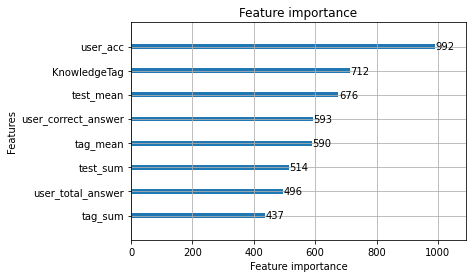

In [370]:
lgb.plot_importance(sk_lgb);

# 7. Prediction 분석

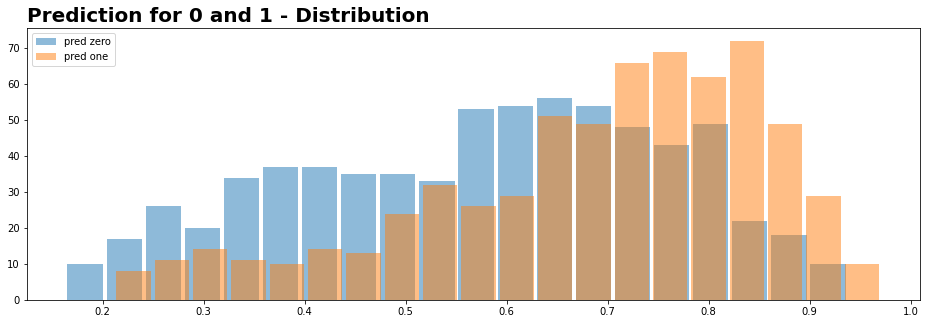

In [455]:
check_pred, check_zero, check_one = distribution_draw(y_valid, valid_result)
# X_valid_df 와 합쳐 학습에 이용된 data 와 정답률 분석하기
check_df = pd.concat([X_valid_df, check_pred], axis=1)

In [456]:
check_df

,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum,answer,pred
4519,2600,492.0,811,0.606658,0.448326,616,0.350352,398,1,0.337509
6897,2114,299.0,604,0.495033,0.779856,1084,0.720202,3130,0,0.686914
7836,9075,567.0,938,0.604478,0.526432,956,0.478781,801,1,0.482882
12721,7782,666.0,943,0.706257,0.627957,876,0.695006,2853,0,0.617988
13439,1721,421.0,717,0.587169,0.682819,775,0.671146,2947,1,0.638591
...,...,...,...,...,...,...,...,...,...,...
2265964,1576,5.0,13,0.384615,0.825926,446,0.814145,1485,0,0.680759
2266062,8420,6.0,17,0.352941,0.559375,1611,0.561064,3565,0,0.389409
2266183,8018,8.0,12,0.666667,0.681159,940,0.673783,2020,0,0.618981
2266398,2718,14.0,16,0.875000,0.537983,1558,0.560000,1820,0,0.790511


## Submission

In [457]:
sub = pd.read_csv(sub_csv_file_path)
sub['prediction'] = result[:,1]
sub.to_csv(f"/opt/ml/output/lgbm_.csv", index=0)
sub

,id,prediction
0,0,0.613538
1,1,0.771900
2,2,0.492840
3,3,0.850110
4,4,0.783349
...,...,...
739,739,0.521980
740,740,0.682537
741,741,0.649395
742,742,0.334567


# 8. TODO
1. Feature engineering
2. parameter tuning
3. 정답을 맞춘 것에 따라 user 추출하기